## Урок 4. Uplift-моделирование

In [1]:
import numpy as np
import pandas as pd; pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split

from sklift.metrics import uplift_at_k
from sklift.viz import plot_uplift_preds
from sklift.models import SoloModel, TwoModels, ClassTransformation

from catboost import CatBoostClassifier

In [2]:
# Загрузка данных

base_data = pd.read_csv('HW_data.csv')

In [3]:
# Преобразование данных

data = base_data.copy()

data = data.rename(columns={'offer': 'treatment', 'conversion': 'target'})
data['treatment'] = np.where(data['treatment'].str.lower() == 'no offer', 0, 1)

In [4]:
# Разбиение на тестовую и тренировочную выборки

TARGET = 'target'
TREATMENT = 'treatment'
FEATURES = list(data.columns.drop([TARGET, TREATMENT]))

CAT_FEATURES = {'used_discount', 'used_bogo', 'zip_code', 'is_referral', 'channel'}

indices_learn, indices_test = train_test_split(data.index, test_size=0.3, random_state=42)

X_train = data.loc[indices_learn, FEATURES]
y_train = data.loc[indices_learn, TARGET]
treat_train = data.loc[indices_learn, TREATMENT]

X_test = data.loc[indices_test, FEATURES]
y_test = data.loc[indices_test, TARGET]
treat_test =  data.loc[indices_test, TREATMENT]

uplift_models_stat = pd.DataFrame(
    columns=['uplift@10%', 'uplift@20%'],
    index=['SoloModel', 'ClassTransformation', 'TwoModels']
)

In [5]:
def get_model_scores(y_test, uplift_sm, treat_test, k_list):
    return [uplift_at_k(y_true=y_test, uplift=uplift_sm, treatment=treat_test, strategy='by_group', k=k) for k in k_list]

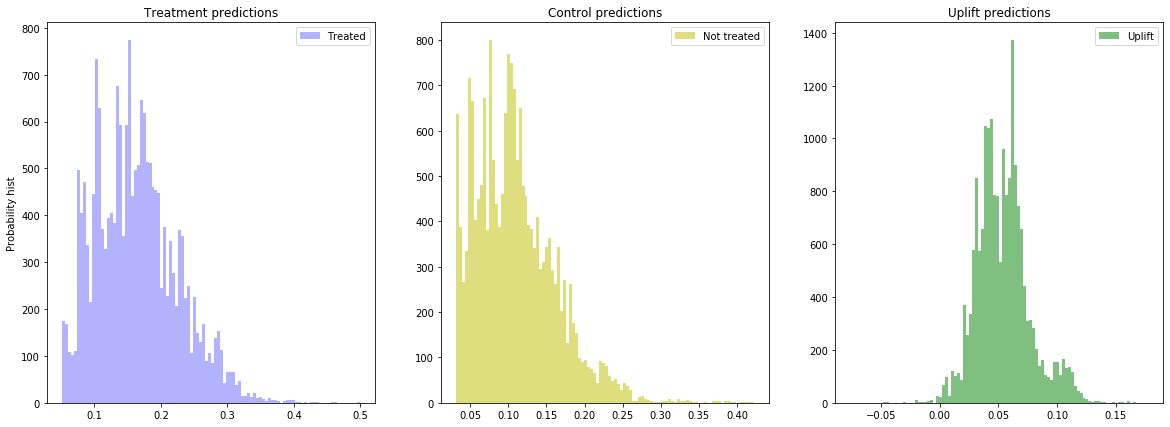

In [6]:
sm = SoloModel(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
sm = sm.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_FEATURES})

uplift_sm = sm.predict(X_test)

uplift_models_stat.loc['SoloModel'] = get_model_scores(y_test, uplift_sm, treat_test, [0.1, 0.2])

# Получим условные вероятности выполнения целевого действия при взаимодействии для каждого объекта
sm_trmnt_preds = sm.trmnt_preds_
# И условные вероятности выполнения целевого действия без взаимодействия для каждого объекта
sm_ctrl_preds = sm.ctrl_preds_

# Отрисуем распределения вероятностей и их разность (uplift)
plot_uplift_preds(trmnt_preds=sm_trmnt_preds, ctrl_preds=sm_ctrl_preds);

In [7]:
ct = ClassTransformation(CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True))
ct = ct.fit(X_train, y_train, treat_train, estimator_fit_params={'cat_features': CAT_FEATURES})

uplift_ct = ct.predict(X_test)

uplift_models_stat.loc['ClassTransformation'] = get_model_scores(y_test, uplift_ct, treat_test, [0.1, 0.2])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: It is recommended to use this approach on treatment balanced data. Current sample size is unbalanced.
  


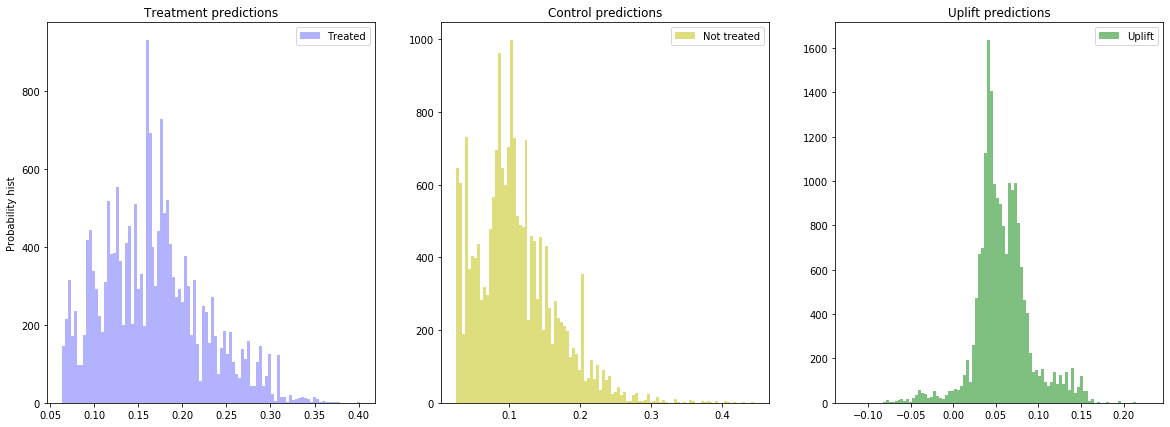

In [8]:
tm = TwoModels(
    estimator_trmnt=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    estimator_ctrl=CatBoostClassifier(iterations=20, thread_count=2, random_state=42, silent=True), 
    method='vanilla'
)
tm = tm.fit(
    X_train, y_train, treat_train,
    estimator_trmnt_fit_params={'cat_features': CAT_FEATURES}, 
    estimator_ctrl_fit_params={'cat_features': CAT_FEATURES}
)

uplift_tm = tm.predict(X_test)


uplift_models_stat.loc['TwoModels'] = get_model_scores(y_test, uplift_tm, treat_test, [0.1, 0.2])

plot_uplift_preds(trmnt_preds=tm.trmnt_preds_, ctrl_preds=tm.ctrl_preds_);

In [9]:
uplift_models_stat

,uplift@10%,uplift@20%
SoloModel,0.112784,0.105302
ClassTransformation,0.119108,0.103868
TwoModels,0.109515,0.0915448


In [10]:
# step 1
uplift_sm = sm.predict(X_test)

# step 2
uplift_df = pd.DataFrame({'uplift': uplift_sm, 'conversion': y_test}).sort_values(by=['uplift'], ascending=False)

# step 3
uplift_df['decile'] = pd.qcut(uplift_df['uplift'], 10)

# step 4
uplift_df.groupby('decile').mean().rename(columns={'uplift': 'mean uplift', 'conversion': 'mean conversion'})

,mean uplift,mean conversion
decile,,
"(-0.0778, 0.0288]",0.018707,0.114984
"(0.0288, 0.0355]",0.032166,0.108164
"(0.0355, 0.0411]",0.038811,0.125000
"(0.0411, 0.0459]",0.043451,0.140479
"(0.0459, 0.053]",0.049122,0.123889
"(0.053, 0.0587]",0.055694,0.140104
"(0.0587, 0.0629]",0.060968,0.158086
"(0.0629, 0.0689]",0.065680,0.170490
"(0.0689, 0.0816]",0.074190,0.160807
